# Multi-label prediction with Planet Amazon dataset


In [11]:
from fastai import *
from fastai.vision import *
import pandas as pd
import numpy as np
import os

## Get data

In [12]:
path = Path('./planet')
path.mkdir(parents=True, exist_ok=True)

!cp -r ../input/planet-understanding-the-amazon-from-space/train_v2.csv ./planet
!cp -r ../input/planet-understanding-the-amazon-from-space/train-jpg ./planet

In [13]:
train_df = pd.read_csv(path/'train_v2.csv')
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [14]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [15]:
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [ ]:
data1 = (src.transform(tfms, size=256)
        .databunch(bs=64).normalize(imagenet_stats))
data2 = (src.transform(tfms, size=256)
        .databunch(bs=64).normalize(imagenet_stats))

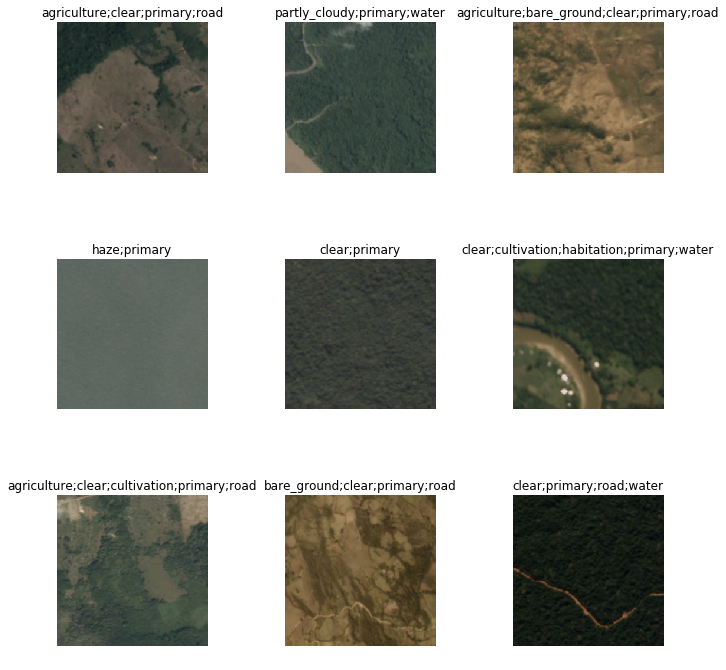

In [16]:
data1.show_batch(rows=3, figsize=(10, 10))

## Training

Will train 2 models and use prediction will be made based on both of them (ensemble learning)

threshold is taken to be 0.2

In [34]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

learn1 = create_cnn(data1, models.resnet50, metrics=[acc_02, f_score])
learn2 = create_cnn(data2, models.resnet34, metrics=[acc_02, f_score])

/opt/conda/lib/python3.6/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


### Training model 1 :- resnet 50

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


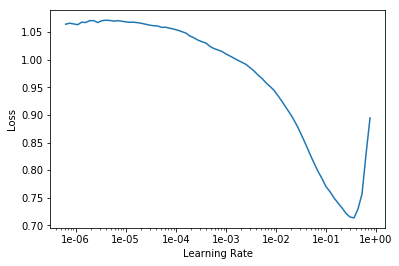

In [18]:
learn1.lr_find()
learn1.recorder.plot()

In [19]:
lr = 1e-2
learn1.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.130423,0.126741,0.944127,0.890418,04:07
1,0.107127,0.099573,0.951350,0.911445,04:05
2,0.096233,0.087451,0.952767,0.922760,04:07
3,0.086308,0.083877,0.956175,0.926125,04:06


In [20]:
learn1.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


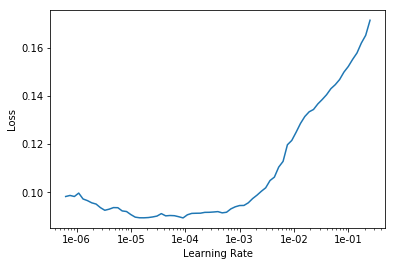

In [21]:
learn1.lr_find()
learn1.recorder.plot()

In [22]:
learn1.fit_one_cycle(2, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.091020,0.086853,0.957105,0.921344,04:24
1,0.083492,0.082222,0.956989,0.926354,04:28


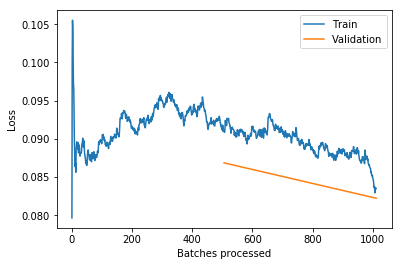

In [23]:
learn1.recorder.plot_losses()

In [24]:
learn1.export('resnet50.pkl', destroy=True)

this Learner object self-destroyed - it still exists, but no longer usable


## Training model 2 :- resnet 34

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


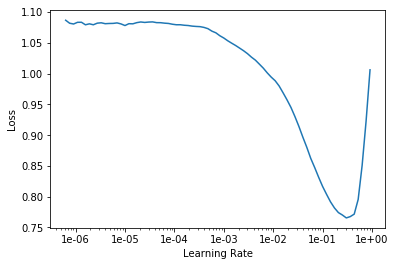

In [25]:
learn2.lr_find()
learn2.recorder.plot()

In [26]:
lr = 1e-2
learn2.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.126514,0.112184,0.939425,0.901267,03:46
1,0.107729,0.097496,0.952367,0.914747,03:44
2,0.097425,0.089396,0.956676,0.922081,03:43
3,0.092563,0.086255,0.955753,0.923766,03:44


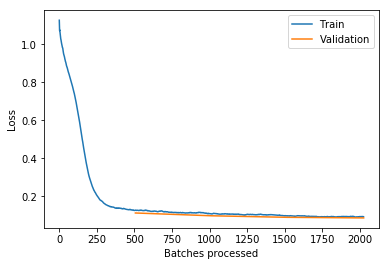

In [27]:
learn2.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


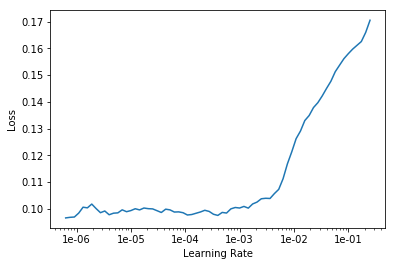

In [28]:
learn2.unfreeze()
learn2.lr_find()
learn2.recorder.plot()

In [29]:
learn2.fit_one_cycle(3, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.100308,0.089904,0.954344,0.921684,03:51
1,0.089907,0.084692,0.960048,0.926722,03:52
2,0.083814,0.083659,0.957672,0.926540,03:54


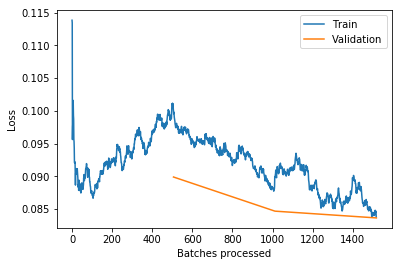

In [30]:
learn2.recorder.plot_losses()

In [31]:
learn2.export('resnet34.pkl', destroy=True)

this Learner object self-destroyed - it still exists, but no longer usable


## Prediction on test set

In [32]:
!cp -r ../input/planet-understanding-the-amazon-from-space/test-jpg-v2 ./planet

In [33]:
test = ImageList.from_folder(path/'test-jpg-v2')

In [36]:
path.ls()

[PosixPath('planet/resnet50.pkl'),
 PosixPath('planet/resnet34.pkl'),
 PosixPath('planet/models'),
 PosixPath('planet/train_v2.csv'),
 PosixPath('planet/test-jpg-v2'),
 PosixPath('planet/train-jpg')]

In [ ]:
learn1 = load_learner(path, 'resnet50.pkl', test=test)
preds1, _ = learn1.TTA(ds_type=DatasetType.Test)

In [ ]:
learn2 = load_learner(path, 'resnet34.pkl', test=test)
preds2, _ = learn12.TTA(ds_type=DatasetType.Test)

In [ ]:
preds = preds1 + preds2

In [0]:
thresh = 0.4
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
df = pd.DataFrame({'image_name':fnames,
                   'tags':labelled_preds},
                  columns=['image_name', 'tags'])

In [0]:
df.to_csv('submission.csv', index=False)

In [ ]:
from IPython.display import FileLink
FileLink('submission.csv')